# Reading the ebird dataset

In [1]:
import sys
assert sys.version_info >= (3, 5)  # make sure we have Python 3.5+
from pyspark.sql import SparkSession, functions, types
from pyspark.conf import SparkConf
from pyspark.sql.functions import substring
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import countDistinct
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import substring
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark.sql.functions import when

spark = SparkSession.builder.appName('ebird_analysis').getOrCreate()
spark.sparkContext.setLogLevel('WARN')

ebird_schema = types.StructType([
        types.StructField("speciesCode",types.StringType()),
        types.StructField("comName",types.StringType()),
        types.StructField("sciName",types.StringType()),
        types.StructField("locId",types.StringType()),
        types.StructField("locName",types.StringType()),
        types.StructField("obsDt",types.StringType()),
        types.StructField("howMany",types.IntegerType()),
        types.StructField("lat",types.StringType()),
        types.StructField("lng",types.StringType()),
        types.StructField("obsValid",types.StringType()),
        types.StructField("obsReviewed",types.StringType()),
        types.StructField("locationPrivate",types.StringType()),
        types.StructField("subId",types.StringType()),
])
ebird_df = spark.read.format('csv').schema(ebird_schema).option("header","true").load("gs://big-data-1-project-storage/cleaned-data/ebird_nonull.csv")
ebird_df = ebird_df.withColumn('year', substring('obsDt', 1,4))\
    .withColumn('month', substring('obsDt', 6,2))\
    .withColumn('day', substring('obsDt', 9,2))

Converting the months to seasons where months 3-5 is Spring, 6-8 is Summer, 9-11 is Fall and 11-2 is Winter.

In [2]:
ebird_df = ebird_df.withColumn("howMany", ebird_df["howMany"].cast(IntegerType())).withColumn("month", ebird_df["month"].cast(IntegerType()))
    
ebird_df=ebird_df.withColumn('seasons', F.when( (F.col("month") == '3') | (F.col("month") == '4') | (F.col("month") == '5') , 'Spring').
    when( (F.col("month") == '6') | (F.col("month") == '7') | (F.col("month") == '8') , 'Summer').
    when( (F.col("month") == '9') | (F.col("month") == '10') | (F.col("month") == '11') , 'Fall').
    when( (F.col("month") == '12') | (F.col("month") == '1') | (F.col("month") == '2') , 'Winter'))

In [3]:
ebird_df.drop("all")
print(ebird_df.show(10))

+-----------+--------------------+--------------------+--------+--------------------+----------------+-------+----------+------------+--------+-----------+---------------+---------+----+-----+---+-------+
|speciesCode|             comName|             sciName|   locId|             locName|           obsDt|howMany|       lat|         lng|obsValid|obsReviewed|locationPrivate|    subId|year|month|day|seasons|
+-----------+--------------------+--------------------+--------+--------------------+----------------+-------+----------+------------+--------+-----------+---------------+---------+----+-----+---+-------+
|     nswowl|Northern Saw-whet...|   Aegolius acadicus| L787133|       Kumdis Slough|2017-03-20 23:15|      1|53.7392187|-132.1612358|    true|      false|           true|S35611913|2017|    3| 20| Spring|
|    wilsni1|      Wilson's Snipe|  Gallinago delicata|L1166559|Hornby Island--Fo...|2017-03-20 21:44|      1|49.4973435|-124.6768427|    true|      false|          false|S35323282

Removing the rows contaning 2022 year in it as the data wouldn't be complete and would cause skewing


In [4]:
df = ebird_df.select(ebird_df.comName,ebird_df.howMany,ebird_df.year,ebird_df.month,ebird_df.day,ebird_df.seasons)
df = df.withColumn("year", df["year"].cast(IntegerType()))
df = df.withColumn("month", df["month"].cast(IntegerType()))
df=df.filter(df.year != 2022)

Converting the years into decades. The ebird dataset for BC started from 1959 till 2021. I have split the years into bins of 10 and only the first decade consists of two extra years and the last decade contains one more extra year.

In [5]:
df=df.withColumn('decade', F.when( (F.col("year") >= 1958) & (F.col("year") <= 1970), '1958-1970').
    when( (F.col("year") >= 1971) & (F.col("year") <= 1980), '1971-1980').
    when( (F.col("year") >= 1981) & (F.col("year") <= 1990), '1981-1990').
    when( (F.col("year") >= 1991) & (F.col("year") <= 2000), '1991-2000').
    when( (F.col("year") >= 2001) & (F.col("year") <= 2010), '2001-2010').    
    when( (F.col("year") >= 2011) & (F.col("year") <= 2021), '2011-2021'))

Converted the dataset from Pyspark dataframe to Pandas dataframe for analysis by using Matplotlib and Seaborn

In [6]:
import pandas as pd
import numpy as np

pandas_df = df.toPandas()
pandas_df.head()

,comName,howMany,year,month,day,seasons,decade
0,Northern Saw-whet Owl,1,2017,3,20,Spring,2011-2021
1,Wilson's Snipe,1,2017,3,20,Spring,2011-2021
2,Cackling Goose,5,2017,3,20,Spring,2011-2021
3,Trumpeter Swan,225,2017,3,20,Spring,2011-2021
4,Tundra Swan,1,2017,3,20,Spring,2011-2021


1.) comname_year consists of sum of unique species across the different seasons and decades.

2.) comname_decade consists of only sum of unique species over the decades only. 

In [7]:
comname_year = pandas_df.groupby(['comName','seasons','decade'], as_index=False)['howMany'].sum()
comname_decade = pandas_df.groupby(['comName','decade'], as_index=False)['howMany'].sum()

# ANALYSIS 1 - DECADEWISE COUNT

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20,15)})

Getting the total count for bird species for the decades

In [53]:
count_decade = comname_decade.groupby(["decade"]).howMany.sum().reset_index()

s= comname_decade.groupby(['decade'])['howMany'].sum().reset_index().sort_values(by='howMany',ascending=False)
s.head(7).style.background_gradient(cmap='Greens')

,decade,howMany
4,2001-2010,16099120
5,2011-2021,10661861
3,1991-2000,7082122
2,1981-1990,3920520
1,1971-1980,2160668
0,1958-1970,503497


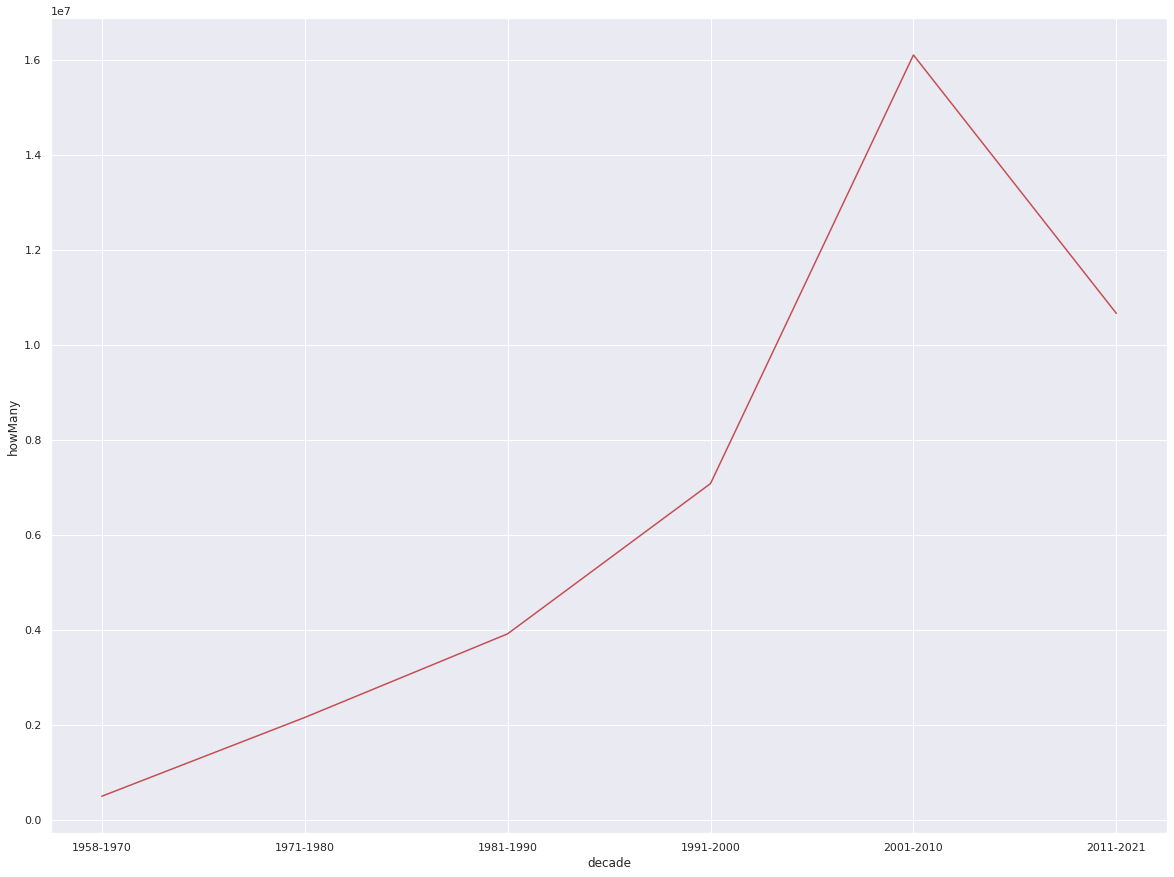

In [54]:
sns.lineplot(x = 'decade',y='howMany', data = count_decade, color = 'r')

# ANALYSIS 2
**Total Count YearWise**


In [55]:
count_year = pandas_df.groupby(["year"]).howMany.sum().reset_index()

s= pandas_df.groupby(['year'])['howMany'].sum().reset_index().sort_values(by='howMany',ascending=False)
s.head(20).style.background_gradient(cmap='Greys')

,year,howMany
48,2007,2456305
47,2006,2038749
51,2010,1647101
46,2005,1575452
45,2004,1518744
50,2009,1489939
49,2008,1406971
44,2003,1362488
42,2001,1322415
43,2002,1280956


In [56]:
count_year = count_year[count_year['year'] > 1959]

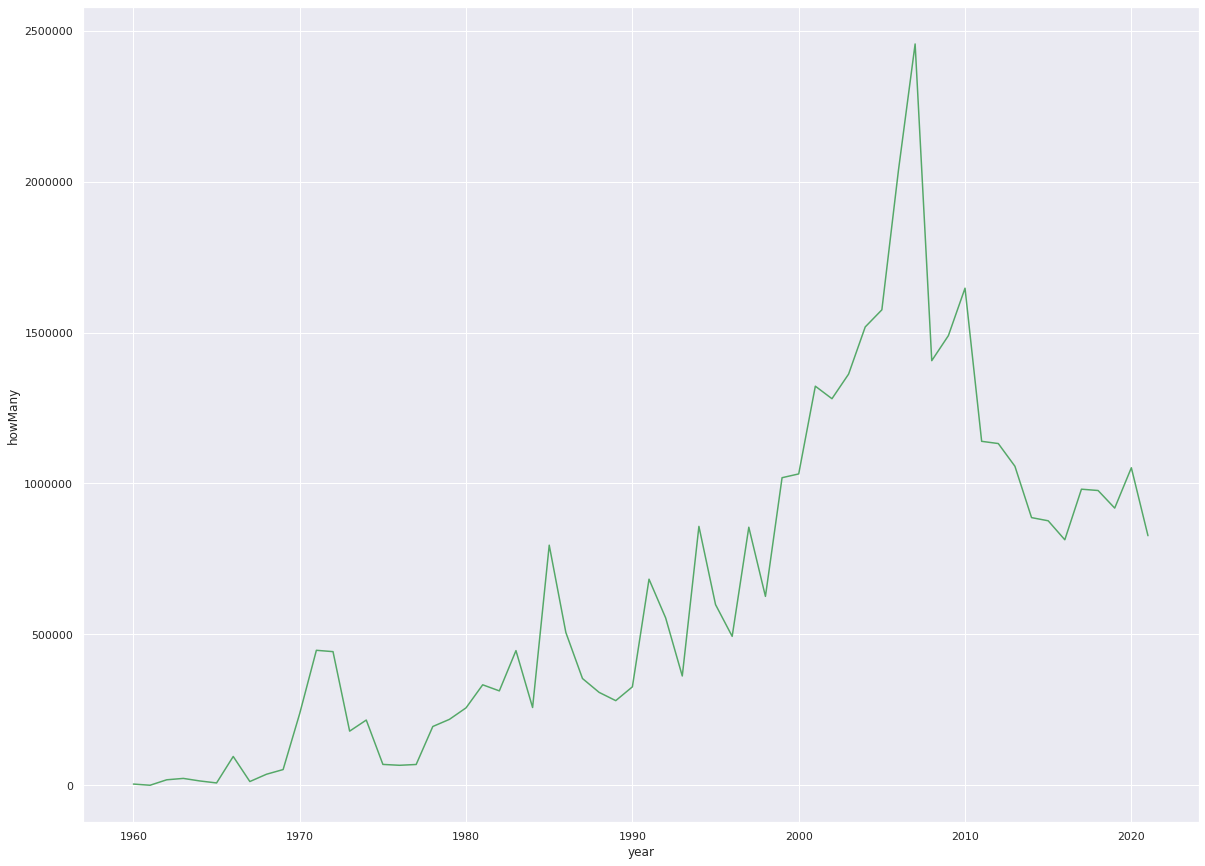

In [57]:
sns.lineplot(x='year',y='howMany', data = count_year, color = 'g')

# ANALYSIS 3
**Endangered birds**


Creating dataframes for the particular decades for comparison by filtering based on decades.

In [58]:
df59_70 = comname_decade[comname_decade['decade'] == '1958-1970']
df71_80 = comname_decade[comname_decade['decade'] == '1971-1980']
df81_90 = comname_decade[comname_decade['decade'] == '1981-1990']
df91_00 = comname_decade[comname_decade['decade'] == '1991-2000']
df01_10 = comname_decade[comname_decade['decade'] == '2001-2010']
df11_21 = comname_decade[comname_decade['decade'] == '2011-2021']

This shows the total count of unique species over the decades.

In [59]:
s= comname_decade.groupby(['decade'])['comName'].count().reset_index().sort_values(by='comName',ascending=False)
s.head(7).style.background_gradient(cmap='Blues')

,decade,comName
5,2011-2021,532
4,2001-2010,466
3,1991-2000,436
2,1981-1990,404
1,1971-1980,374
0,1958-1970,317


Joined the filtered dataframes from above and performed a left join keeping all the values for the first decade and comparing the differences in species based on their sightings for the particular decades. The difference is then sorted in an increasing order. 

**For Decade 6 and Decade 1 Comparison**

In [64]:
endangered = df59_70.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1959-1970', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1959-1970']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,howMany_1959-1970,decade_y,howMany_2011-2021,difference
108,Fork-tailed Storm-Petrel,1958-1970,5253,2011-2021,4649.0,-604.0
102,Emperor Goose,1958-1970,5,2011-2021,1.0,-4.0
243,Scissor-tailed Flycatcher,1958-1970,4,2011-2021,2.0,-2.0
187,Northern Wheatear,1958-1970,1,2011-2021,1.0,0.0


**For Decade 6 and Decade 2 Comparison**

In [65]:
endangered = df71_80.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1971-1980', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1971-1980']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_80_10_diff.sort_values('difference')
endangered_difference.head()

,comName,decade_x,howMany_1971-1980,decade_y,howMany_2011-2021,difference
137,Glaucous-winged Gull,1971-1980,193176,2011-2021,110125.0,-83051.0
123,Emperor Goose,1971-1980,7,2011-2021,1.0,-6.0
135,Garganey,1971-1980,5,2011-2021,2.0,-3.0


**For Decade 6 and Decade 3 Comparison**

In [66]:
endangered = df81_90.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1981-1990', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1981-1990']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,howMany_1981-1990,decade_y,howMany_2011-2021,difference
153,Glaucous-winged Gull,1981-1990,223906,2011-2021,110125.0,-113781.0
218,Mallard,1981-1990,180048,2011-2021,118057.0,-61991.0
320,Snow Goose,1981-1990,800100,2011-2021,777256.0,-22844.0
232,Northern Fulmar,1981-1990,15792,2011-2021,9355.0,-6437.0
312,Sharp-tailed Sandpiper,1981-1990,200,2011-2021,165.0,-35.0


Created a barplot for the top three species which have gone down in count over the years by plotting them.

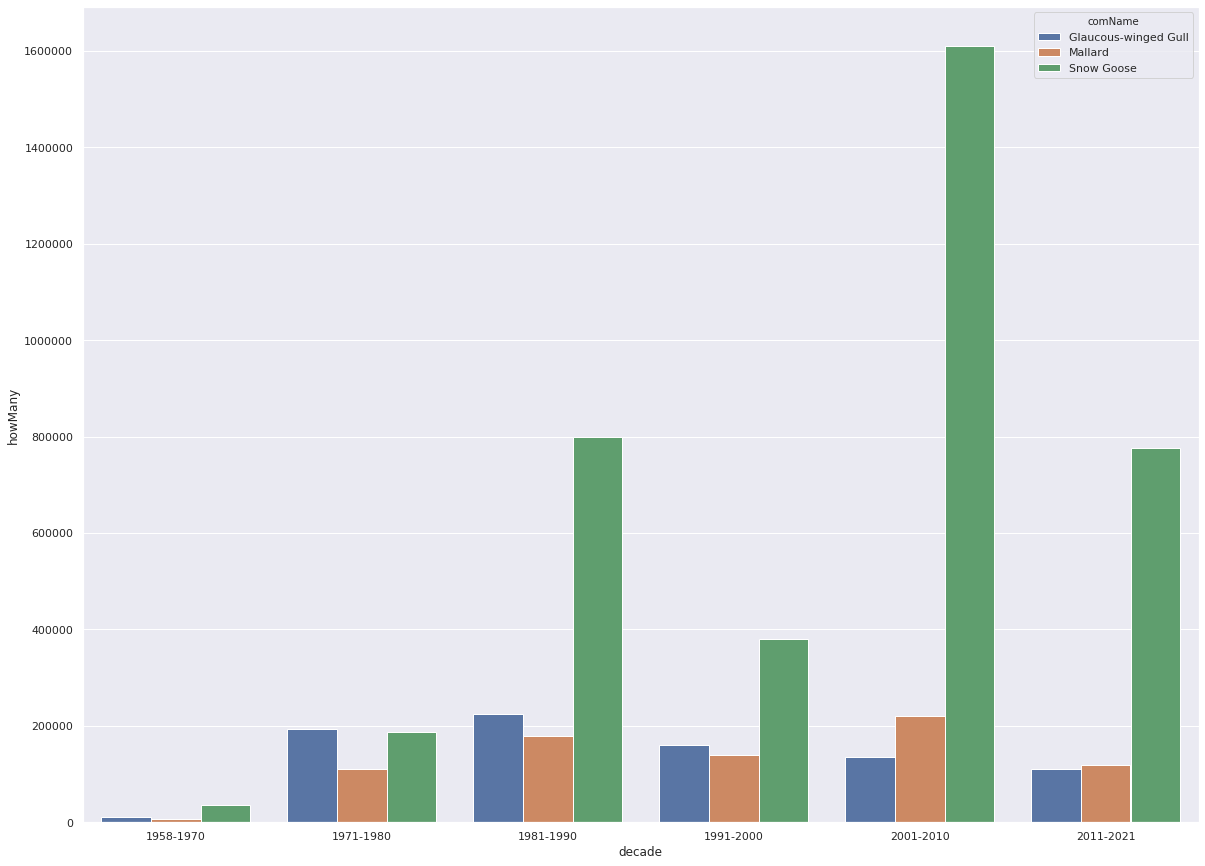

In [68]:
plot = comname_decade[(comname_decade['comName'] == 'Glaucous-winged Gull') | (comname_decade['comName'] == 'Mallard') | (comname_decade['comName'] == 'Snow Goose')]
sns.barplot(x = "decade", y = "howMany", data=plot, hue="comName")

**For Decade 6 and Decade 4 Comparison**

In [69]:
endangered = df91_00.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1991-2000', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1991-2000']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,howMany_1991-2000,decade_y,howMany_2011-2021,difference
398,Western Sandpiper,1991-2000,1896261,2011-2021,496161.0,-1400100.0
161,Glaucous-winged Gull,1991-2000,161124,2011-2021,110125.0,-50999.0
234,Mallard,1991-2000,139488,2011-2021,118057.0,-21431.0
339,Short-billed Dowitcher,1991-2000,36008,2011-2021,16244.0,-19764.0
220,Lesser Scaup,1991-2000,79814,2011-2021,61442.0,-18372.0


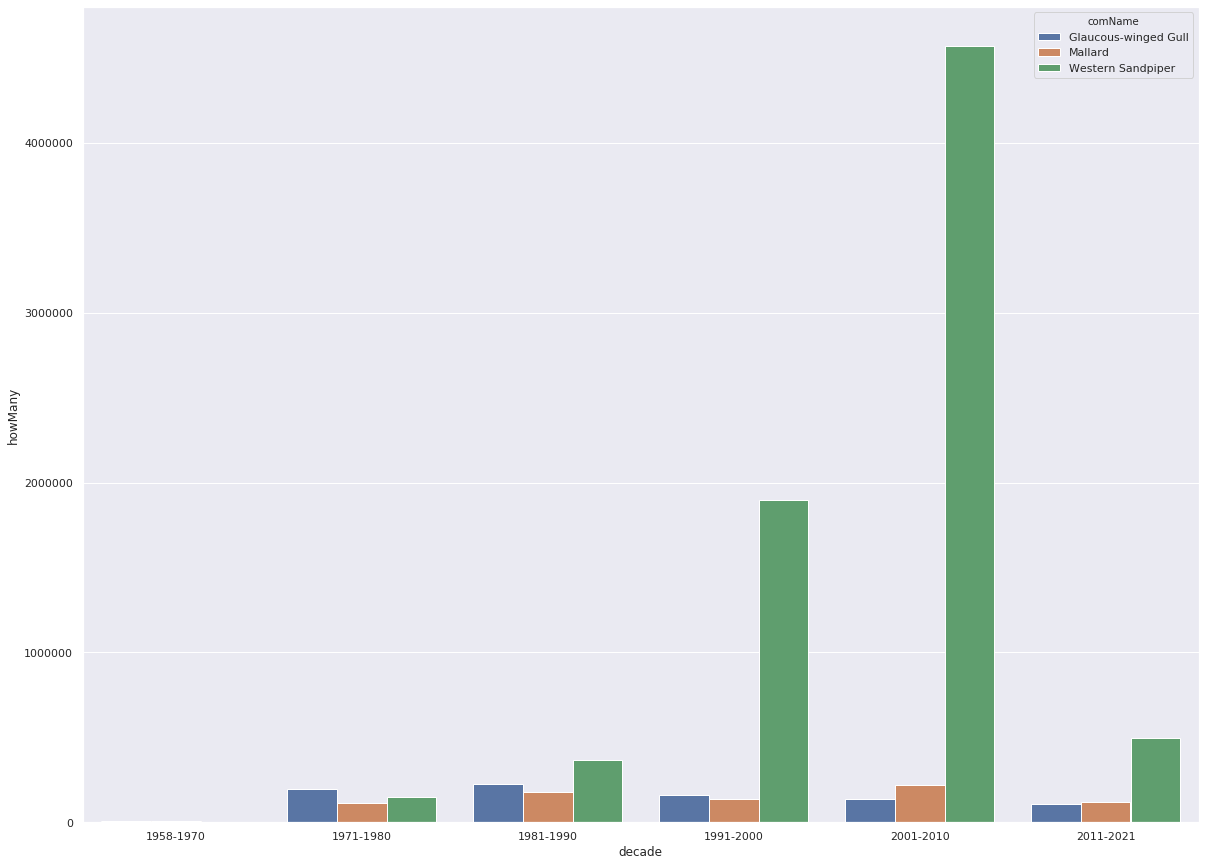

In [70]:
plot = comname_decade[(comname_decade['comName'] == 'Western Sandpiper') | (comname_decade['comName'] == 'Glaucous-winged Gull') | (comname_decade['comName'] == 'Mallard')]
sns.barplot(x = "decade", y = "howMany", data=plot, hue="comName")

**For Decade 6 and Decade 5 Comparison**

In [71]:
endangered = df01_10.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_2001-2010', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = (endangered['howMany_2011-2021'] - endangered['howMany_2001-2010'])

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,howMany_2001-2010,decade_y,howMany_2011-2021,difference
427,Western Sandpiper,2001-2010,4571641,2011-2021,496161.0,-4075480.0
142,Dunlin,2001-2010,4000412,2011-2021,1811715.0,-2188697.0
377,Snow Goose,2001-2010,1610888,2011-2021,777256.0,-833632.0
331,Ring-billed Gull,2001-2010,308421,2011-2021,136879.0,-171542.0
5,American Coot,2001-2010,302761,2011-2021,188986.0,-113775.0


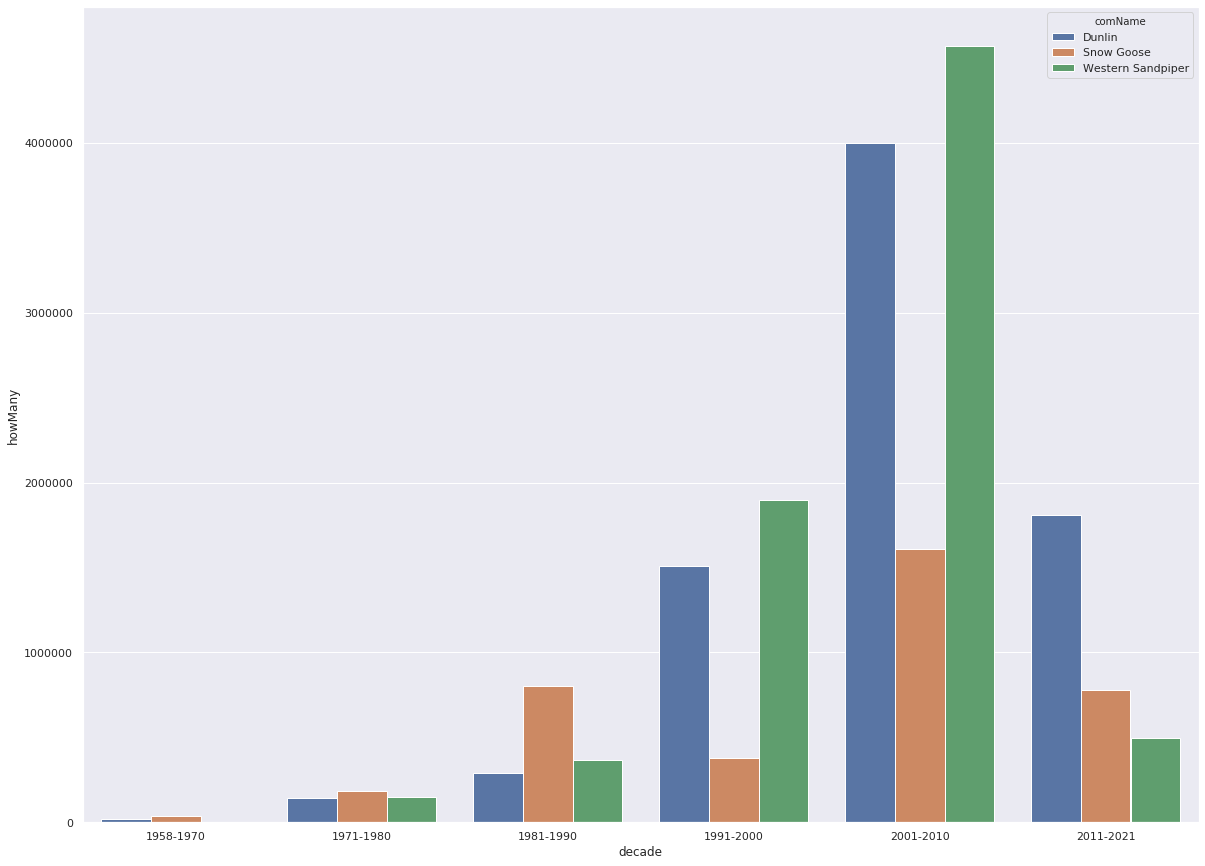

In [72]:
plot = comname_decade[(comname_decade['comName'] == 'Western Sandpiper') | (comname_decade['comName'] == 'Dunlin') | (comname_decade['comName'] == 'Snow Goose')]

sns.barplot(x = "decade", y = "howMany", data=plot, hue="comName")

# ANALYSIS 4
**Increasing birds**


Taking the positive difference over the decades and plotting the graph for the top 3 species increase count.

**For Decade 6 and Decade 1 Comparison**

In [73]:
endangered = df59_70.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1959-1970', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1959-1970']

endangered_difference = endangered[endangered['difference'] > 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.tail()

,comName,decade_x,howMany_1959-1970,decade_y,howMany_2011-2021,difference
180,Northern Pintail,1958-1970,4241,2011-2021,272330.0,268089.0
266,Surf Scoter,1958-1970,6323,2011-2021,320918.0,314595.0
292,Western Sandpiper,1958-1970,1434,2011-2021,496161.0,494727.0
252,Snow Goose,1958-1970,35797,2011-2021,777256.0,741459.0
97,Dunlin,1958-1970,21657,2011-2021,1811715.0,1790058.0


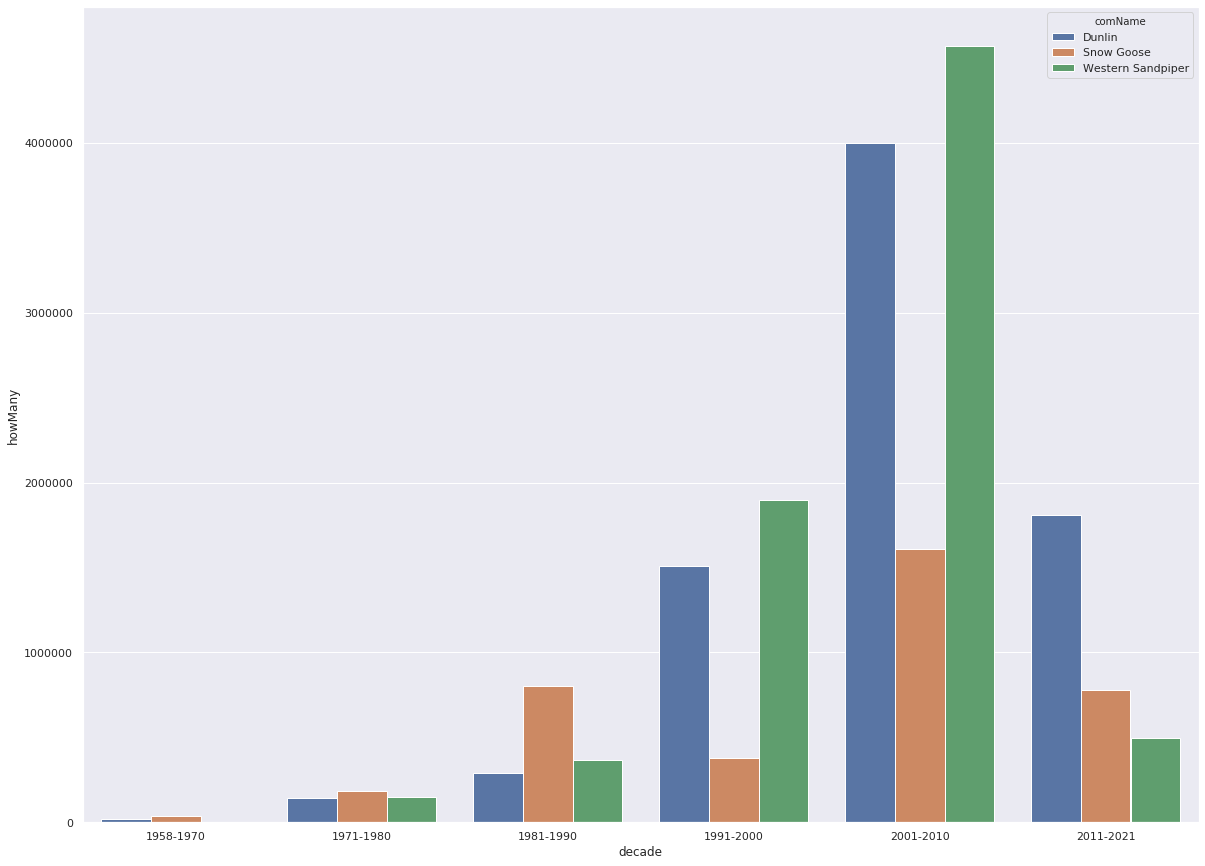

In [74]:
plot = comname_decade[(comname_decade['comName'] == 'Dunlin') | (comname_decade['comName'] == 'Snow Goose') | (comname_decade['comName'] == 'Western Sandpiper')]
sns.barplot(x = "decade", y = "howMany", data=plot, hue="comName")

**For Decade 6 and Decade 2 Comparison**

In [75]:
endangered = df71_80.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1971-1980', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1971-1980']

endangered_difference = endangered[endangered['difference'] > 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.tail()

,comName,decade_x,howMany_1971-1980,decade_y,howMany_2011-2021,difference
214,Northern Pintail,1971-1980,44513,2011-2021,272330.0,227817.0
313,Surf Scoter,1971-1980,60776,2011-2021,320918.0,260142.0
342,Western Sandpiper,1971-1980,150248,2011-2021,496161.0,345913.0
297,Snow Goose,1971-1980,186655,2011-2021,777256.0,590601.0
117,Dunlin,1971-1980,141094,2011-2021,1811715.0,1670621.0


**For Decade 6 and Decade 3 Comparison**

In [76]:
endangered = df81_90.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1981-1990', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1981-1990']

endangered_difference = endangered[endangered['difference'] > 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.tail()

,comName,decade_x,howMany_1981-1990,decade_y,howMany_2011-2021,difference
39,Black-bellied Plover,1981-1990,51912,2011-2021,207741.0,155829.0
80,Cackling Goose,1981-1990,898,2011-2021,163939.0,163041.0
111,Common Murre,1981-1990,23328,2011-2021,208602.0,185274.0
336,Surf Scoter,1981-1990,82424,2011-2021,320918.0,238494.0
128,Dunlin,1981-1990,289124,2011-2021,1811715.0,1522591.0


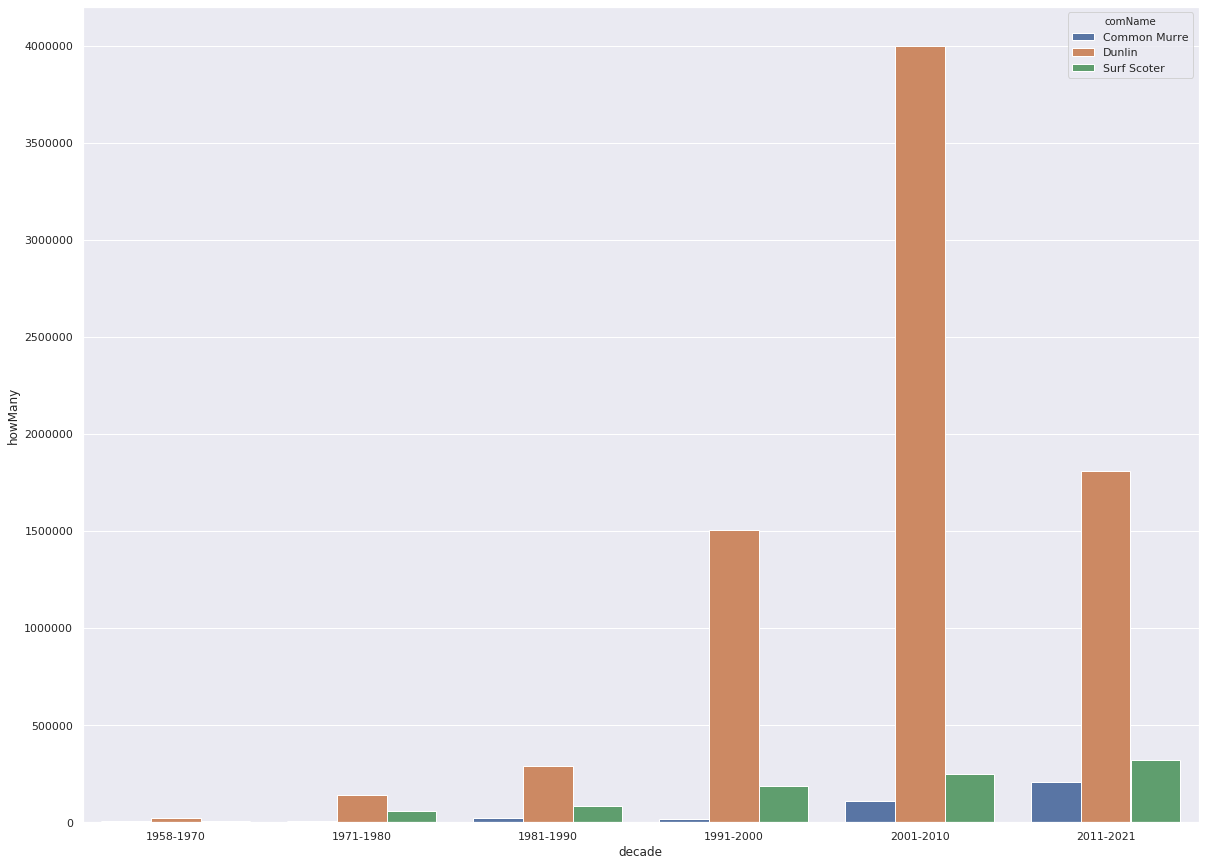

In [77]:
plot = comname_decade[(comname_decade['comName'] == 'Dunlin') | (comname_decade['comName'] == 'Surf Scoter') | (comname_decade['comName'] == 'Common Murre')]
sns.barplot(x = "decade", y = "howMany", data=plot, hue="comName")

**For Decade 6 and Decade 4 Comparison**

In [78]:
endangered = df91_00.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1991-2000', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1991-2000']

endangered_difference = endangered[endangered['difference'] > 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.tail()

,comName,decade_x,howMany_1991-2000,decade_y,howMany_2011-2021,difference
5,American Crow,1991-2000,31783,2011-2021,186936.0,155153.0
82,Cackling Goose,1991-2000,2284,2011-2021,163939.0,161655.0
114,Common Murre,1991-2000,17477,2011-2021,208602.0,191125.0
133,Dunlin,1991-2000,1507271,2011-2021,1811715.0,304444.0
349,Snow Goose,1991-2000,380441,2011-2021,777256.0,396815.0


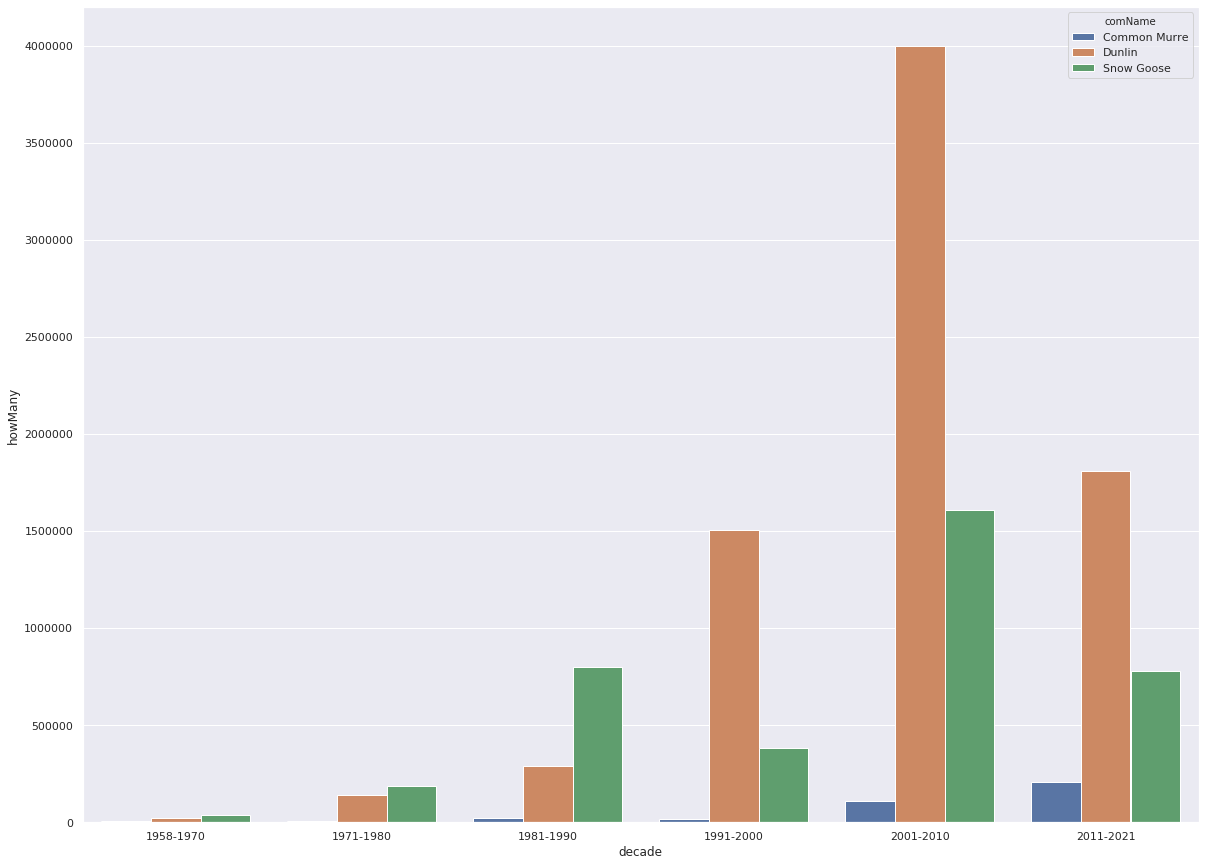

In [79]:
plot = comname_decade[(comname_decade['comName'] == 'Snow Goose') | (comname_decade['comName'] == 'Dunlin') | (comname_decade['comName'] == 'Common Murre')]
sns.barplot(x = "decade", y = "howMany", data=plot, hue="comName")

**For Decade 6 and Decade 5 Comparison**

In [80]:
endangered = df01_10.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_2001-2010', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = (endangered['howMany_2011-2021'] - endangered['howMany_2001-2010'])

endangered_difference = endangered[endangered['difference'] > 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.tail()

,comName,decade_x,howMany_2001-2010,decade_y,howMany_2011-2021,difference
46,Black-bellied Plover,2001-2010,113229,2011-2021,207741.0,94512.0
123,Common Murre,2001-2010,108453,2011-2021,208602.0,100149.0
6,American Crow,2001-2010,86739,2011-2021,186936.0,100197.0
271,Northern Pintail,2001-2010,164532,2011-2021,272330.0,107798.0
91,Cackling Goose,2001-2010,28565,2011-2021,163939.0,135374.0


The best difference in increase is shown in the 5th Decade and 6th Decade across these top 3 species.

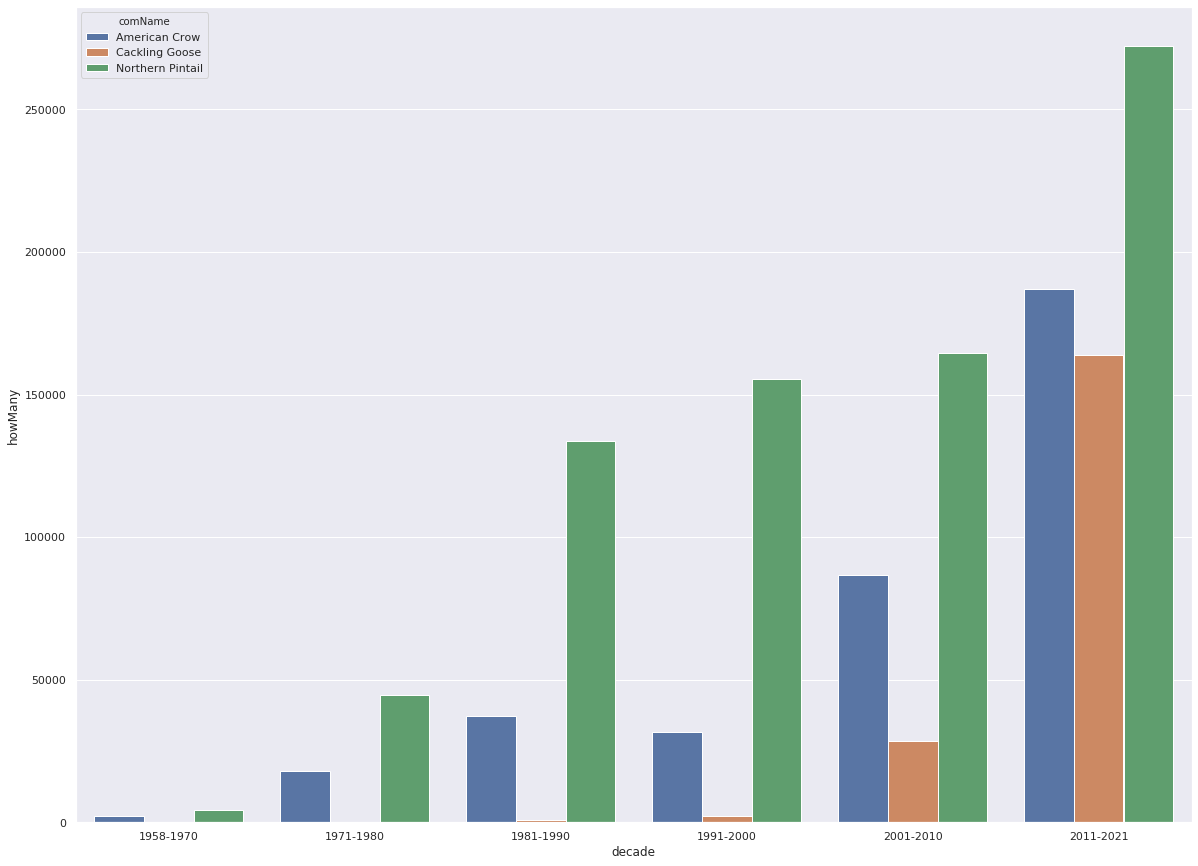

In [81]:
plot = comname_decade[(comname_decade['comName'] == 'Cackling Goose') | (comname_decade['comName'] == 'Northern Pintail') | (comname_decade['comName'] == 'American Crow')]

sns.barplot(x = "decade", y = "howMany", data=plot, hue="comName")

# Analysis 5
**Winter Bird Counts**

Grouping the dataset based on Decade and Seasons. Filtering the dataset based on Winter season and decade. Plotting the species whihch have gone down over the years for the winter season.

In [82]:
comname_seasons = pandas_df.groupby(['comName','decade','seasons'], as_index=False)['howMany'].sum()
comname_season_winter = comname_seasons[comname_seasons['seasons'] == 'Winter']

In [83]:
comname_season_winter.head()

,comName,decade,seasons,howMany
1,Acorn Woodpecker,2001-2010,Winter,4
5,Acorn Woodpecker,2011-2021,Winter,10
29,American Avocet,1991-2000,Winter,42
33,American Avocet,2001-2010,Winter,27
40,American Bittern,1958-1970,Winter,12


In [84]:
df59_70 = comname_season_winter[comname_season_winter['decade'] == '1959-1970']
df71_80 = comname_season_winter[comname_season_winter['decade'] == '1971-1980']
df81_90 = comname_season_winter[comname_season_winter['decade'] == '1981-1990']
df91_00 = comname_season_winter[comname_season_winter['decade'] == '1991-2000']
df01_10 = comname_season_winter[comname_season_winter['decade'] == '2001-2010']
df11_21 = comname_season_winter[comname_season_winter['decade'] == '2011-2021']

**Decade 1 with Decade 6 comparison**

In [88]:
endangered = df59_70.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1959-1970', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1959-1970']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,decade_x,seasons_x,howMany_1959-1970,comName,decade_y,seasons_y,howMany_2011-2021,difference


**Decade 2 with Decade 6 comparison**

In [89]:
endangered = df71_80.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1971-1980', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1971-1980']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,seasons_x,howMany_1971-1980,decade_y,seasons_y,howMany_2011-2021,difference
76,Glaucous-winged Gull,1971-1980,Winter,88914,2011-2021,Winter,37924.0,-50990.0
10,American Wigeon,1971-1980,Winter,108032,2011-2021,Winter,67030.0,-41002.0
70,European Starling,1971-1980,Winter,64398,2011-2021,Winter,37888.0,-26510.0
112,Mallard,1971-1980,Winter,59355,2011-2021,Winter,50664.0,-8691.0
196,Western Grebe,1971-1980,Winter,13640,2011-2021,Winter,12798.0,-842.0


The decade 2 and decade 6 comparison showed the sharpest drop for species over the winter season. The top 3 species have been chosen here as well. 

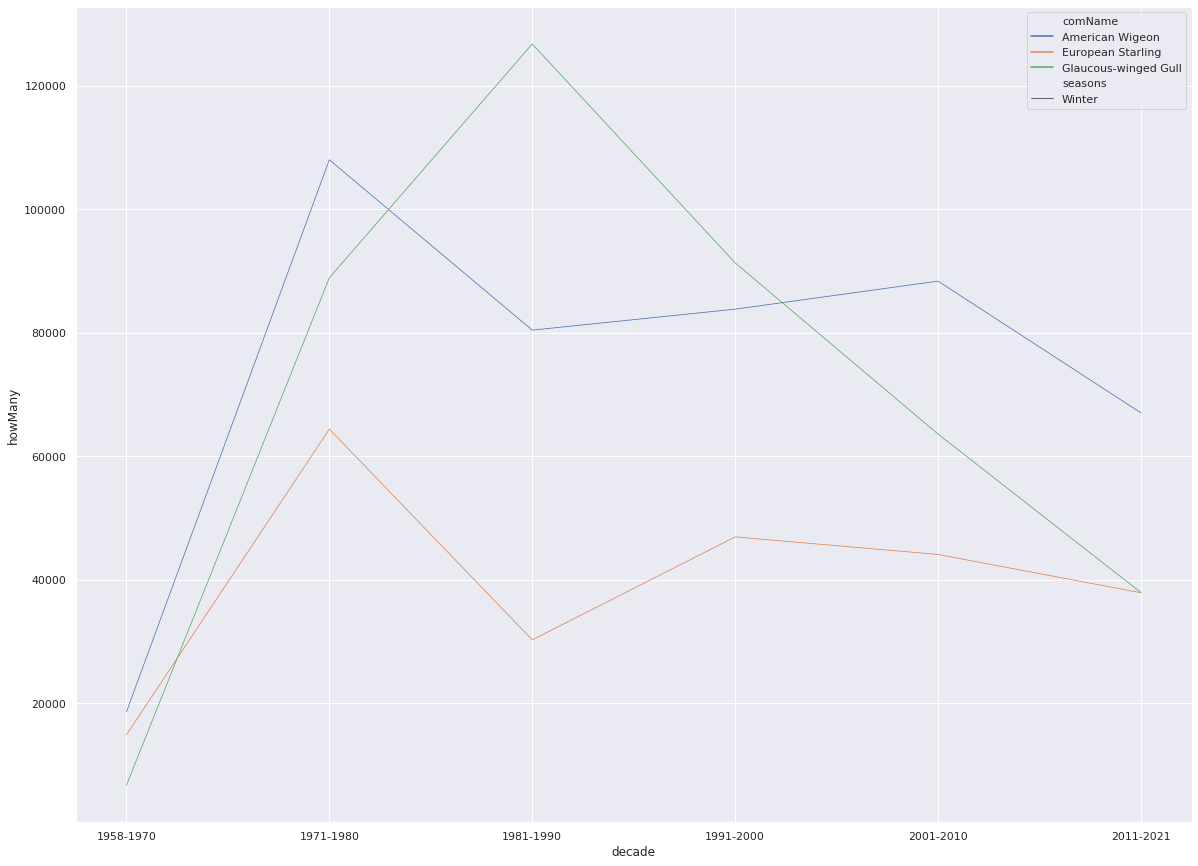

In [90]:
plot = comname_season_winter[(comname_season_winter['comName'] == 'Glaucous-winged Gull') | (comname_season_winter['comName'] == 'American Wigeon') | (comname_season_winter['comName'] == 'European Starling')]

sns.lineplot(x = "decade", y = "howMany", data=plot, hue="comName", size = 'seasons')

**Decade 3 with Decade 6 comparison**

In [91]:
endangered = df81_90.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1981-1990', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1981-1990']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,seasons_x,howMany_1981-1990,decade_y,seasons_y,howMany_2011-2021,difference
88,Glaucous-winged Gull,1981-1990,Winter,126796,2011-2021,Winter,37924.0,-88872.0
144,Northern Pintail,1981-1990,Winter,84622,2011-2021,Winter,57119.0,-27503.0
11,American Wigeon,1981-1990,Winter,80438,2011-2021,Winter,67030.0,-13408.0
129,Mallard,1981-1990,Winter,56180,2011-2021,Winter,50664.0,-5516.0
224,Western Grebe,1981-1990,Winter,17013,2011-2021,Winter,12798.0,-4215.0


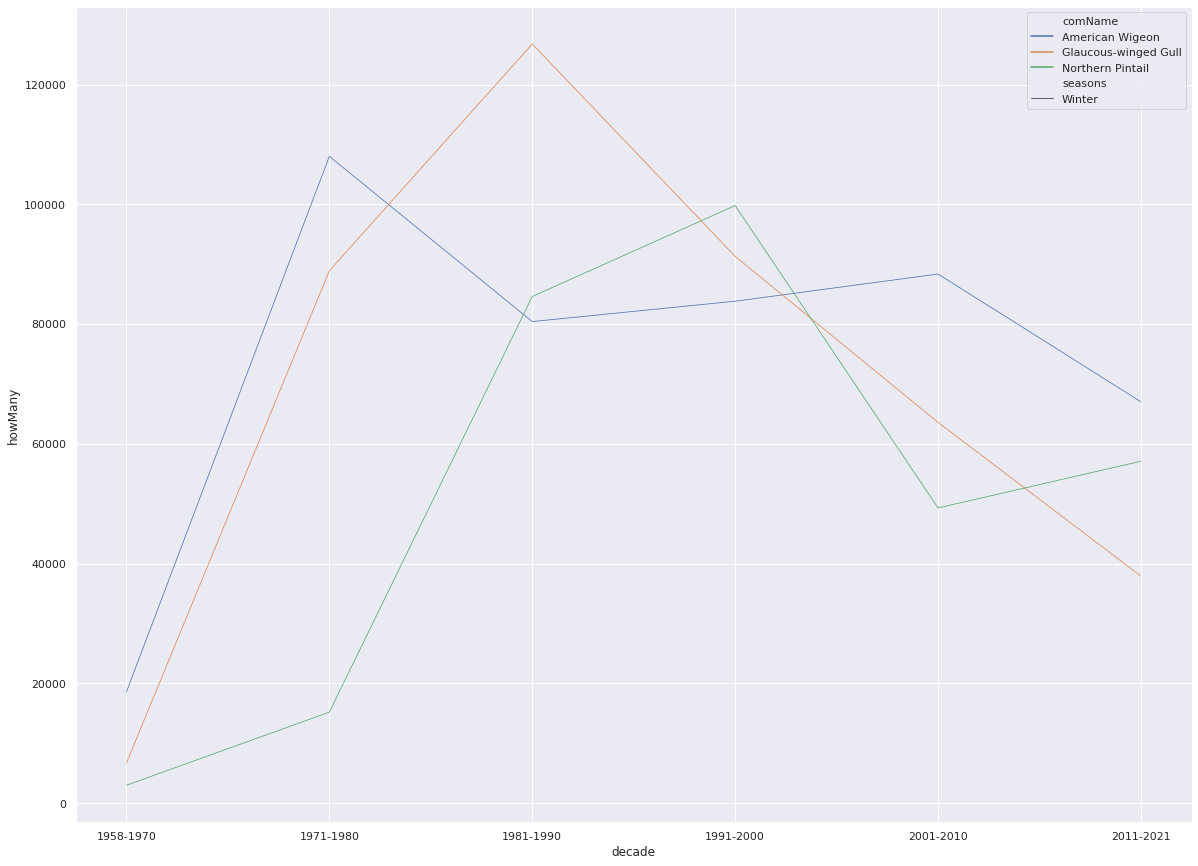

In [92]:
plot = comname_season_winter[(comname_season_winter['comName'] == 'Glaucous-winged Gull') | (comname_season_winter['comName'] == 'Northern Pintail') | (comname_season_winter['comName'] == 'American Wigeon')]
sns.lineplot(x = "decade", y = "howMany", data=plot, hue="comName", size = 'seasons')

**Decade 4 with Decade 6 comparison**

In [93]:
endangered = df91_00.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1991-2000', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1991-2000']

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,seasons_x,howMany_1991-2000,decade_y,seasons_y,howMany_2011-2021,difference
101,Glaucous-winged Gull,1991-2000,Winter,91333,2011-2021,Winter,37924.0,-53409.0
163,Northern Pintail,1991-2000,Winter,99810,2011-2021,Winter,57119.0,-42691.0
138,Lesser Scaup,1991-2000,Winter,48283,2011-2021,Winter,20089.0,-28194.0
12,American Wigeon,1991-2000,Winter,83834,2011-2021,Winter,67030.0,-16804.0
146,Mallard,1991-2000,Winter,67263,2011-2021,Winter,50664.0,-16599.0


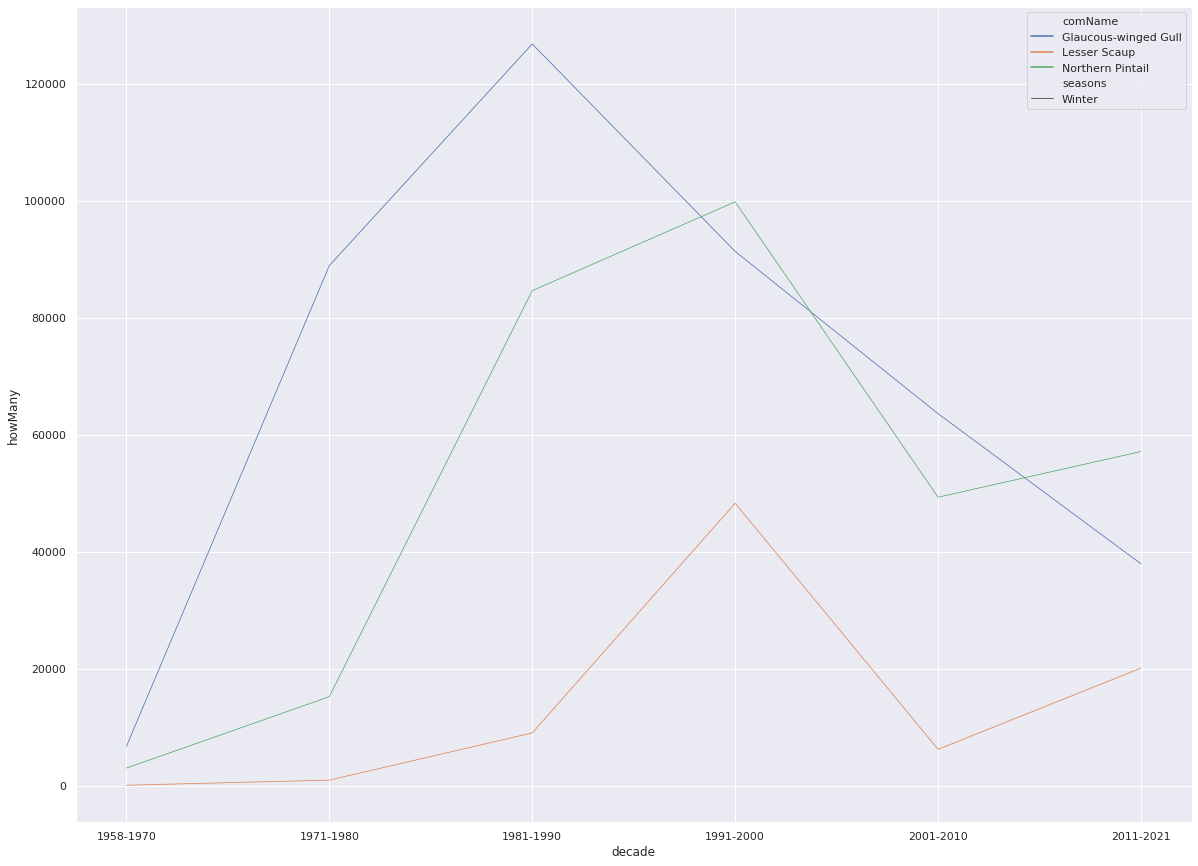

In [94]:
plot = comname_season_winter[(comname_season_winter['comName'] == 'Glaucous-winged Gull') | (comname_season_winter['comName'] == 'Northern Pintail') | (comname_season_winter['comName'] == 'Lesser Scaup')]
sns.lineplot(x = "decade", y = "howMany", data=plot, hue="comName", size = 'seasons')

**Decade 5 with Decade 6 comparison**

In [95]:
endangered = df01_10.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_2001-2010', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = (endangered['howMany_2011-2021'] - endangered['howMany_2001-2010'])

endangered_difference = endangered[endangered['difference'] <= 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.head()

,comName,decade_x,seasons_x,howMany_2001-2010,decade_y,seasons_y,howMany_2011-2021,difference
237,Snow Goose,2001-2010,Winter,391542,2011-2021,Winter,252231.0,-139311.0
108,Glaucous-winged Gull,2001-2010,Winter,63595,2011-2021,Winter,37924.0,-25671.0
157,Mallard,2001-2010,Winter,73800,2011-2021,Winter,50664.0,-23136.0
247,Surf Scoter,2001-2010,Winter,70039,2011-2021,Winter,47438.0,-22601.0
13,American Wigeon,2001-2010,Winter,88377,2011-2021,Winter,67030.0,-21347.0


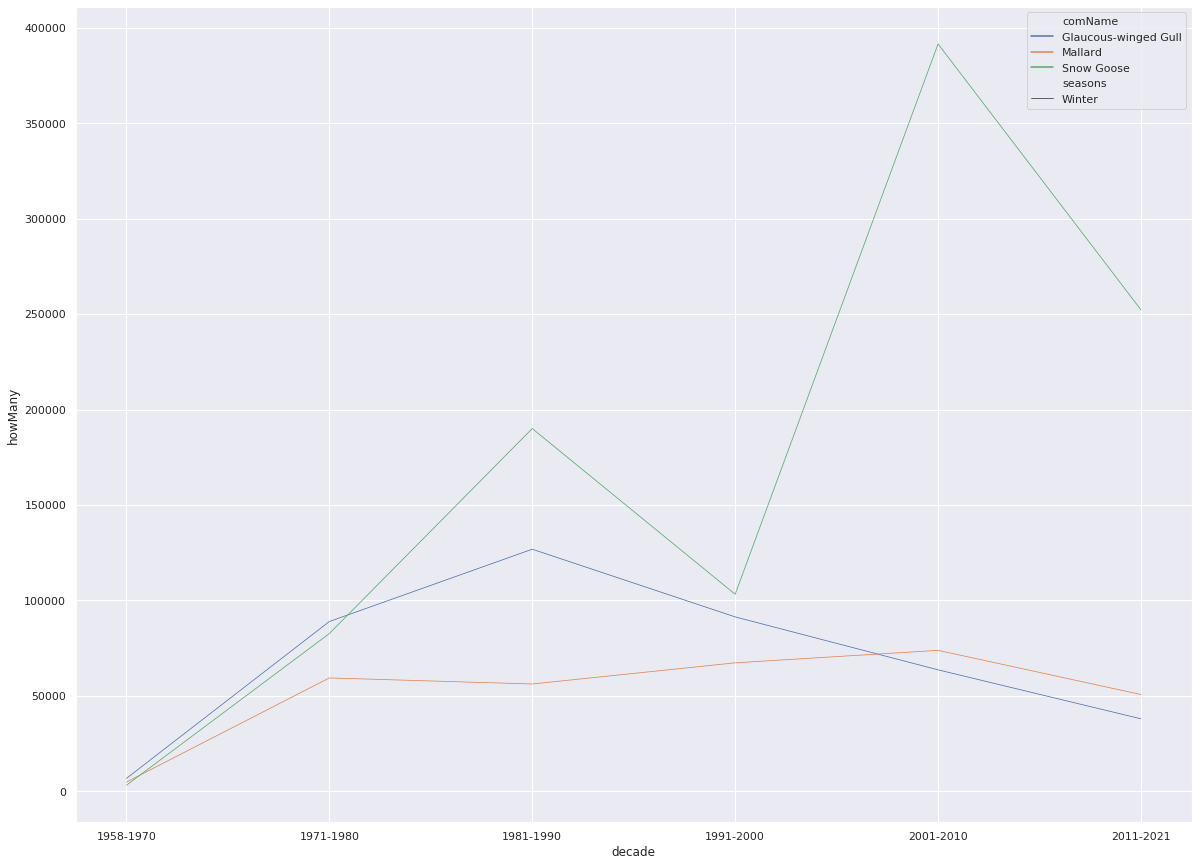

In [96]:
plot = comname_season_winter[(comname_season_winter['comName'] == 'Snow Goose') | (comname_season_winter['comName'] == 'Glaucous-winged Gull') | (comname_season_winter['comName'] == 'Mallard')]
sns.lineplot(x = "decade", y = "howMany", data=plot, hue="comName", size = 'seasons')

# ANALYSIS 6
**Except winter seasons bird count increase**

Filtered the dataset for the remaining seasons which would be Spring, Summer and Fall and plotted the difference for top 3 species which showed the maximum increase in count.

In [97]:
comname_seasons = pandas_df.groupby(['comName','seasons','decade'], as_index=False)['howMany'].sum()
comname_season_nonwinter = comname_seasons[(comname_seasons['seasons'] == 'Summer') | (comname_seasons['seasons'] == 'Fall') | (comname_seasons['seasons'] == 'Spring')]

In [98]:
df59_70 = comname_season_nonwinter[comname_season_nonwinter['decade'] == '1958-1970']
df71_80 = comname_season_nonwinter[comname_season_nonwinter['decade'] == '1971-1980']
df81_90 = comname_season_nonwinter[comname_season_nonwinter['decade'] == '1981-1990']
df91_00 = comname_season_nonwinter[comname_season_nonwinter['decade'] == '1991-2000']
df01_10 = comname_season_nonwinter[comname_season_nonwinter['decade'] == '2001-2010']
df11_21 = comname_season_nonwinter[comname_season_nonwinter['decade'] == '2011-2021']

In [106]:
endangered = df59_70.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_1959-1970', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = endangered['howMany_2011-2021'] - endangered['howMany_1959-1970']

endangered_difference = endangered[endangered['difference'] > 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered_difference.tail(15)

,comName,seasons_x,decade_x,howMany_1959-1970,seasons_y,decade_y,howMany_2011-2021,difference
1966,Surf Scoter,Spring,1958-1970,2898,Spring,2011-2021,182270.0,179372.0
1963,Surf Scoter,Fall,1958-1970,1273,Spring,2011-2021,182270.0,180997.0
1969,Surf Scoter,Summer,1958-1970,200,Spring,2011-2021,182270.0,182070.0
1870,Snow Goose,Spring,1958-1970,1145,Spring,2011-2021,205193.0,204048.0
1873,Snow Goose,Summer,1958-1970,3,Spring,2011-2021,205193.0,205190.0
1866,Snow Goose,Fall,1958-1970,31524,Fall,2011-2021,319591.0,288067.0
1869,Snow Goose,Spring,1958-1970,1145,Fall,2011-2021,319591.0,318446.0
1872,Snow Goose,Summer,1958-1970,3,Fall,2011-2021,319591.0,319588.0
2167,Western Sandpiper,Summer,1958-1970,1215,Spring,2011-2021,321568.0,320353.0
2161,Western Sandpiper,Fall,1958-1970,146,Spring,2011-2021,321568.0,321422.0


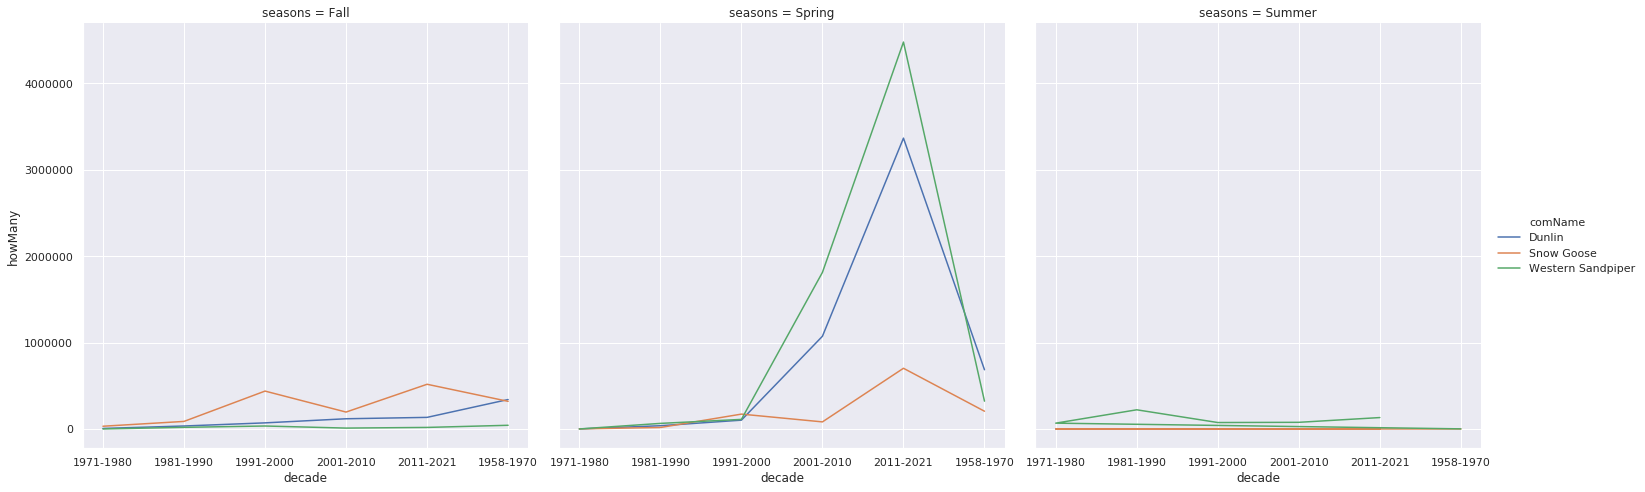

In [102]:
plot = comname_season_nonwinter[(comname_season_nonwinter['comName'] == 'Dunlin') | (comname_season_nonwinter['comName'] == 'Western Sandpiper') | (comname_season_nonwinter['comName'] == 'Snow Goose')]
sns.relplot(x = "decade", y = "howMany", data=plot, hue="comName", col = 'seasons',kind ='line', height = 7)

In [108]:
endangered = df01_10.merge(df11_21, on='comName', how='left')
endangered.rename(columns={'howMany_x': 'howMany_2001-2010', 'howMany_y': 'howMany_2011-2021'}, inplace=True)
endangered['difference'] = (endangered['howMany_2011-2021'] - endangered['howMany_2001-2010'])

endangered_difference = endangered[endangered['difference'] > 0]
endangered_difference = endangered_difference.sort_values('difference')
endangered.tail(20)

,comName,seasons_x,decade_x,howMany_2001-2010,seasons_y,decade_y,howMany_2011-2021,difference
3400,Yellow-breasted Chat,Summer,2001-2010,175,Spring,2011-2021,299.0,124.0
3401,Yellow-breasted Chat,Summer,2001-2010,175,Summer,2011-2021,718.0,543.0
3402,Yellow-headed Blackbird,Fall,2001-2010,328,Fall,2011-2021,763.0,435.0
3403,Yellow-headed Blackbird,Fall,2001-2010,328,Spring,2011-2021,3803.0,3475.0
3404,Yellow-headed Blackbird,Fall,2001-2010,328,Summer,2011-2021,8051.0,7723.0
3405,Yellow-headed Blackbird,Spring,2001-2010,3810,Fall,2011-2021,763.0,-3047.0
3406,Yellow-headed Blackbird,Spring,2001-2010,3810,Spring,2011-2021,3803.0,-7.0
3407,Yellow-headed Blackbird,Spring,2001-2010,3810,Summer,2011-2021,8051.0,4241.0
3408,Yellow-headed Blackbird,Summer,2001-2010,8590,Fall,2011-2021,763.0,-7827.0
3409,Yellow-headed Blackbird,Summer,2001-2010,8590,Spring,2011-2021,3803.0,-4787.0


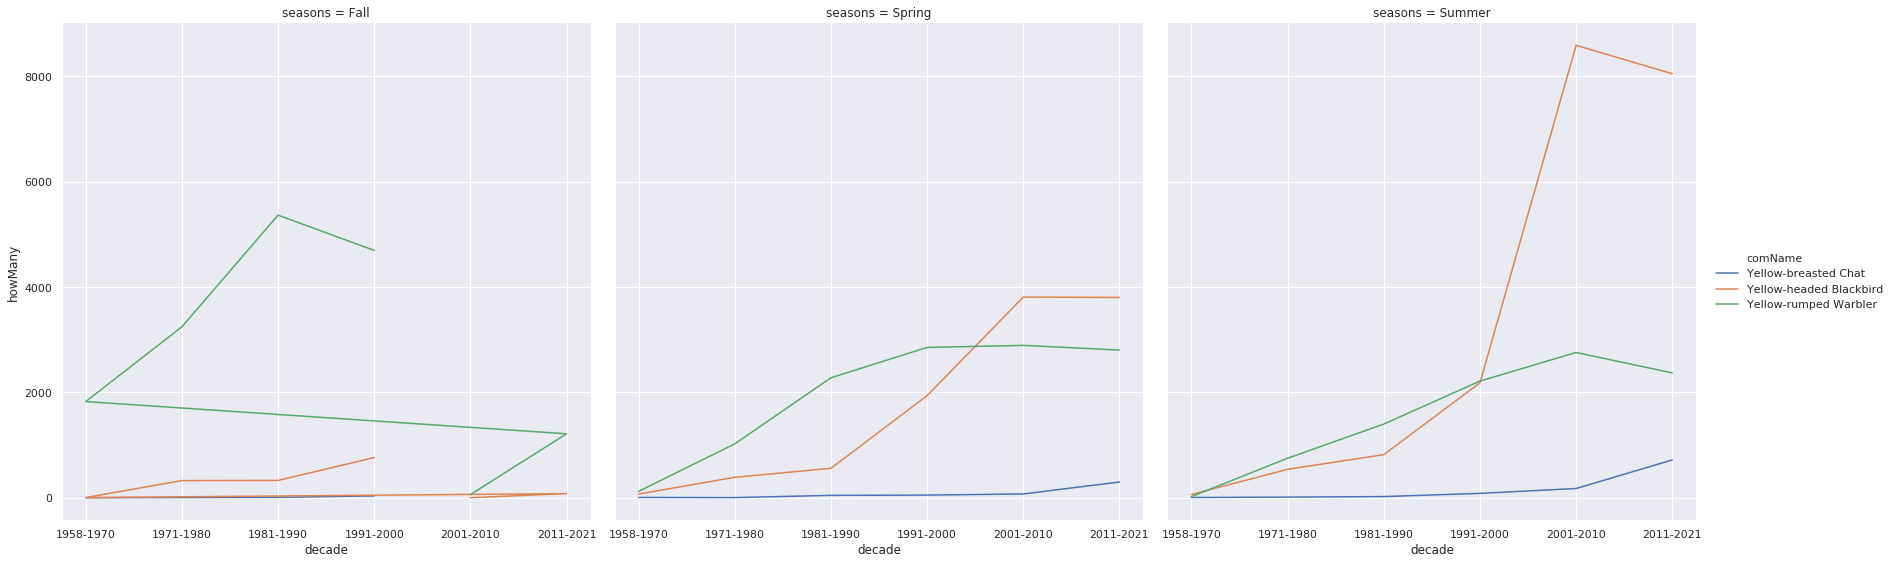

In [109]:
plot5 = comname_season_nonwinter[(comname_season_nonwinter['comName'] == 'Yellow-rumped Warbler') | (comname_season_nonwinter['comName'] == 'Yellow-headed Blackbird') | (comname_season_nonwinter['comName'] == 'Yellow-breasted Chat')]


sns.relplot(x = "decade", y = "howMany", data=plot5, hue="comName", col = 'seasons',kind ='line', height = 8)

# Species not spotted 

There are two species which have not been spotted over some years.

1. Crested Myna - Spotted last in 2003.
2. Black Headed Gull - Spotted last in 2019.

In [114]:
comname_extinct = pandas_df.groupby(['comName','year'], as_index=False)['howMany'].sum()

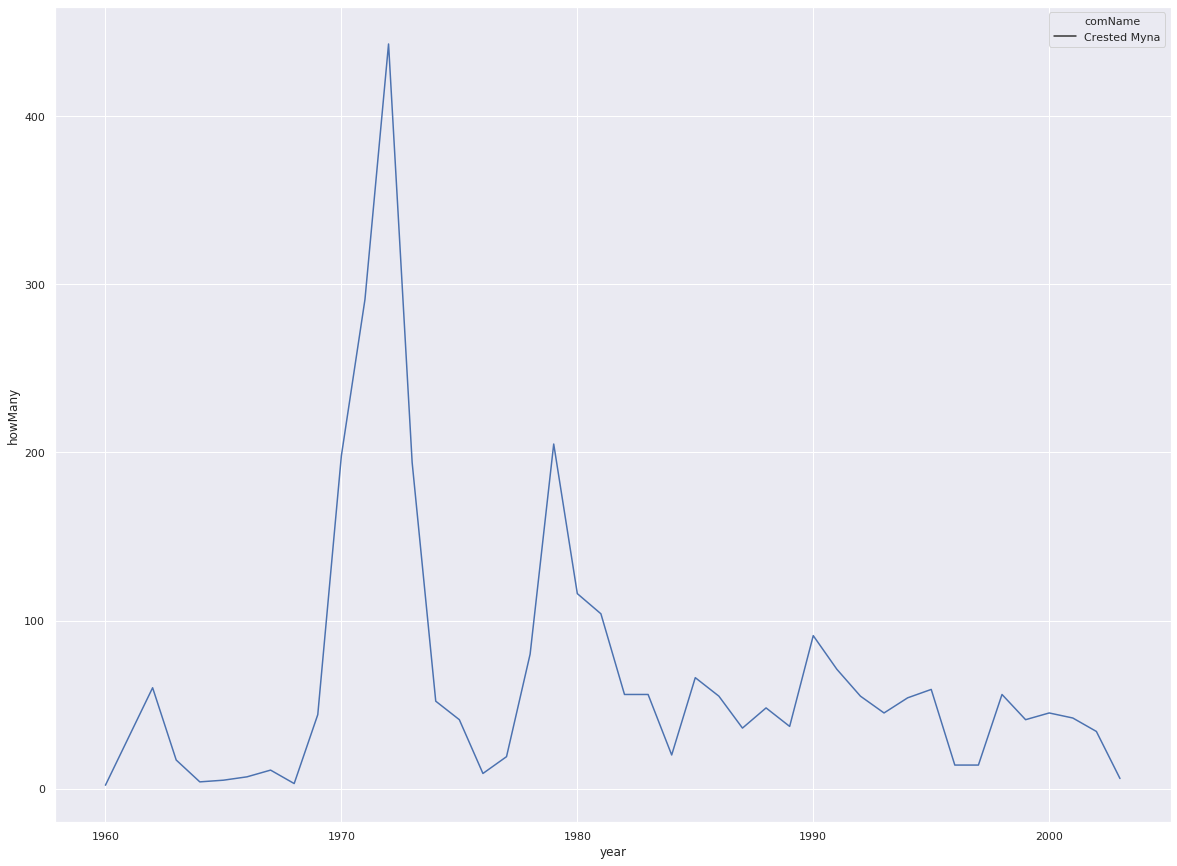

In [116]:
Crested_Myna = comname_extinct[comname_extinct['comName'] == 'Crested Myna']
sns.lineplot(x = 'year',y='howMany', data = Crested_Myna, color = 'b', style = 'comName')

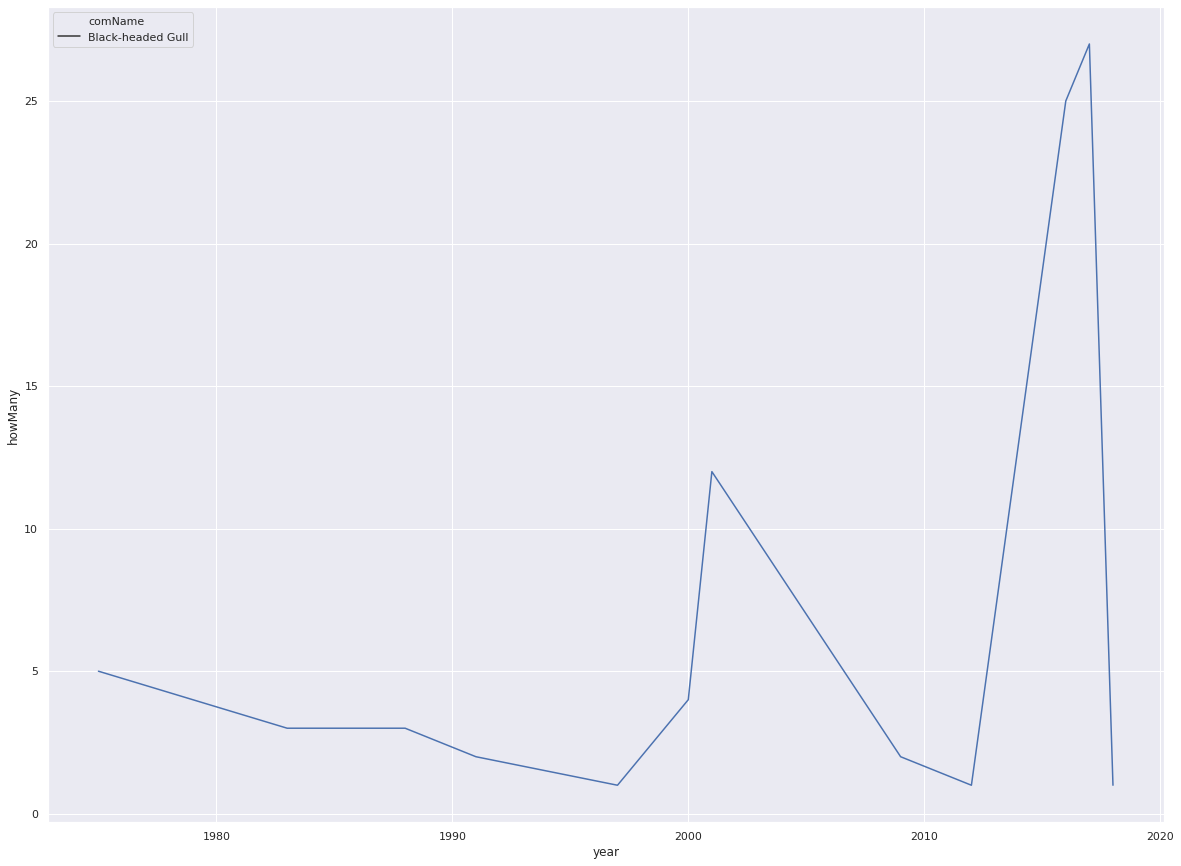

In [118]:
Black_Headed_Gull = comname_extinct[comname_extinct['comName'] == 'Black-headed Gull']
sns.lineplot(x = 'year',y='howMany', data = Black_Headed_Gull, color = 'b', style = 'comName')